In [2]:
pip install panda ics python-dateutil numpy matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


La moyenne de la chaleur du chauffage central pour la pièce B110 lorsqu'il est activé est de 10662.806859205777 Joules.
Le chauffage central dans la pièce B110 a été activé pendant 507.8333333333333 heures.
La dépense énergétique totale pour la pièce B110 est de 2.55 €.
La moyenne de la chaleur du chauffage central pour la pièce B111 lorsqu'il est activé est de 9263.231897222946 Joules.
Le chauffage central dans la pièce B111 a été activé pendant 642.1666666666666 heures.
La dépense énergétique totale pour la pièce B111 est de 2.80 €.
La moyenne de la chaleur du chauffage central pour la pièce B201 lorsqu'il est activé est de 12423.211243611602 Joules.
Le chauffage central dans la pièce B201 a été activé pendant 489.1666666666667 heures.
La dépense énergétique totale pour la pièce B201 est de 2.86 €.
La moyenne de la chaleur du chauffage central pour la pièce B202 lorsqu'il est activé est de 8323.645206113959 Joules.
Le chauffage central dans la pièce B202 a été activé pendant 359.8333

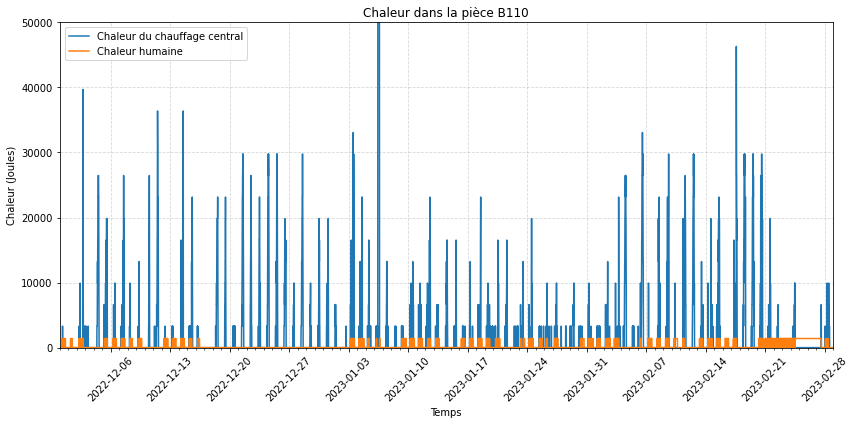

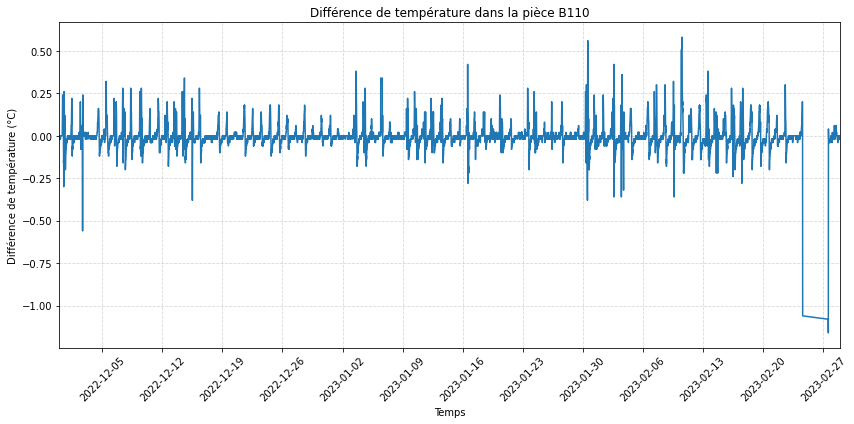

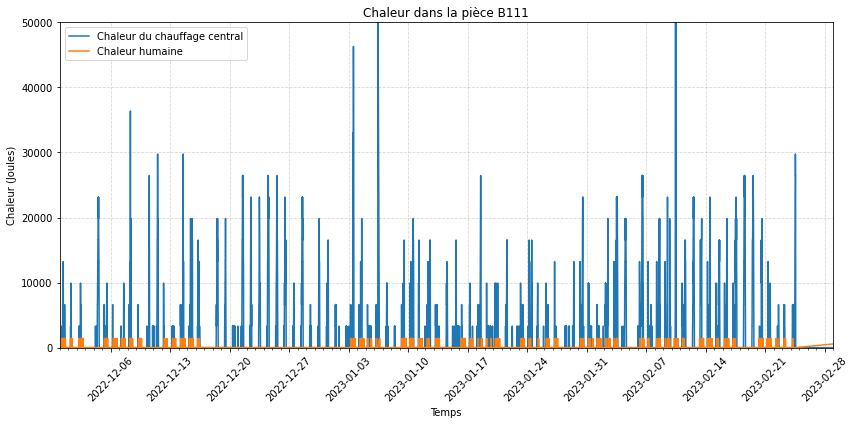

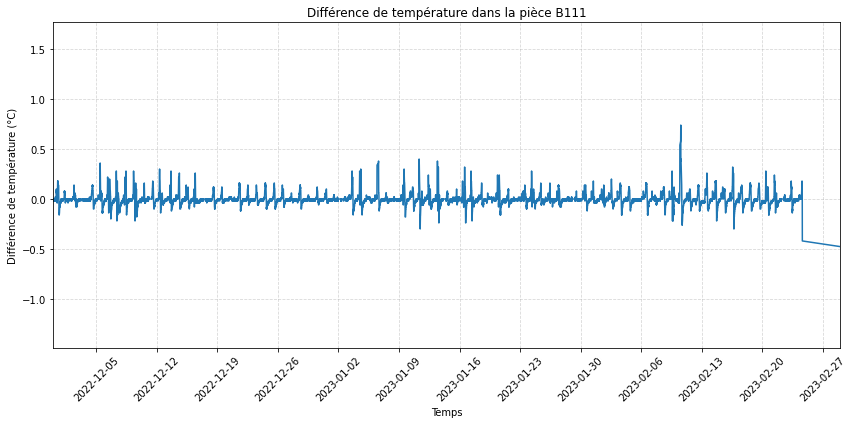

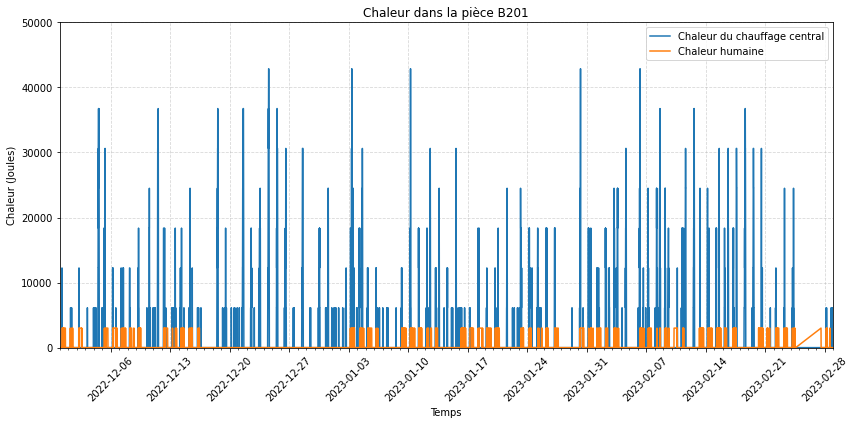

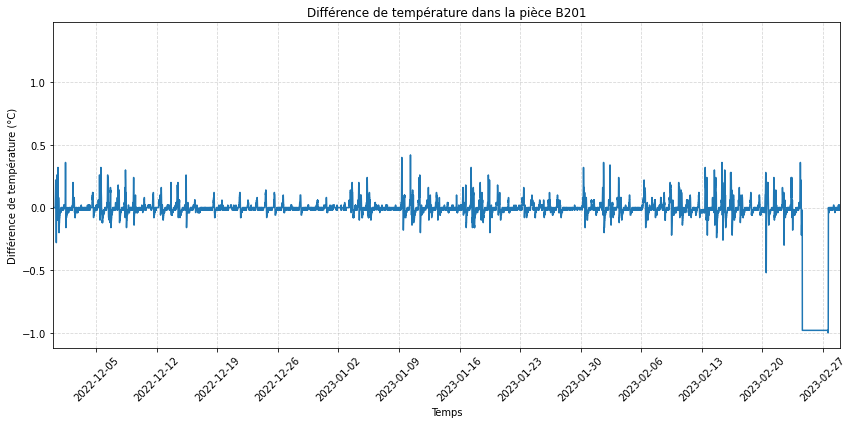

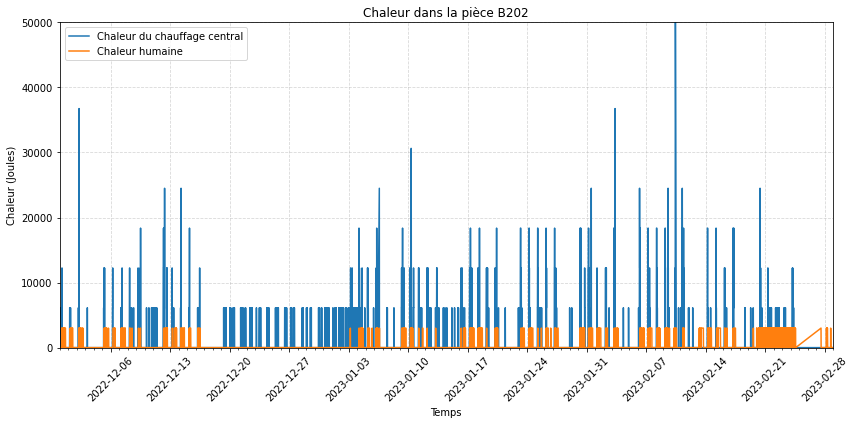

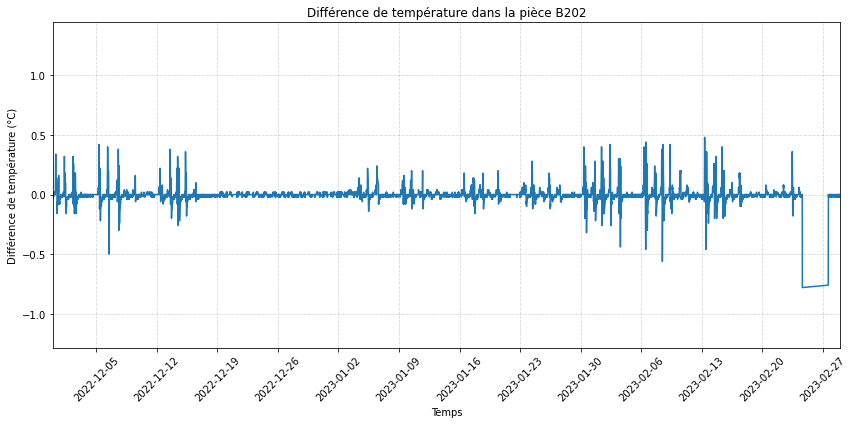

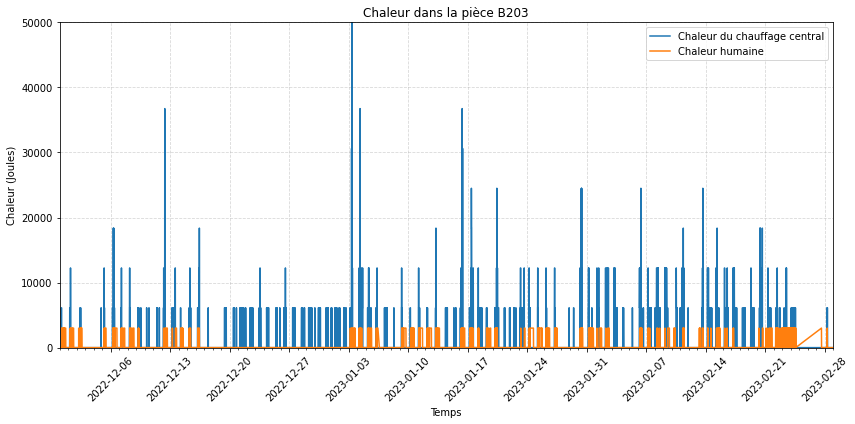

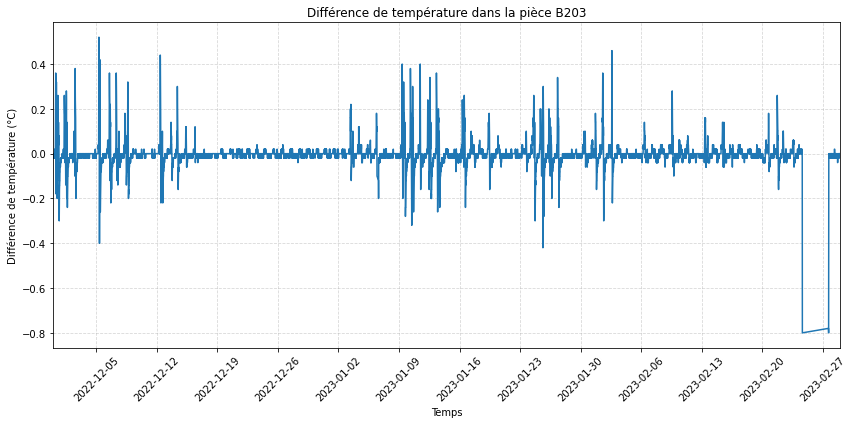

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Constantes physiques
AIR_DENSITY = 1.225
SPECIFIC_HEAT_CAPACITY_AIR = 1000
cost_per_kwh = 0.282
total_building_volume = 24000  # Volume total du bâtiment en m³
cost_per_cubic_meter_list = []

# Charger les données et convertir la colonne 'time' en objets datetime
data = pd.read_csv("export.csv")
data['time'] = pd.to_datetime(data['time'])
data['time'] = data['time'].dt.round('min')

# Lisser les données de température avec une fenêtre glissante
window_size = 5
smoothed_temperature_data = data['temperature'].rolling(window=window_size, center=True).mean()
data['smoothed_temperature'] = smoothed_temperature_data

# Filtrer les données par pièce et les grouper
room_names = ["B110", "B111", "B201", "B202", "B203"]
filtered_data = data[data["room"].isin(room_names)]
grouped_data = filtered_data.groupby("room")

# Informations sur les pièces (nombre de personnes et volume)
room_people = {"B110": 14, "B111": 14, "B201": 30, "B202": 30, "B203": 30}
room_volume = {"B110": 135, "B111": 135, "B201": 250, "B202": 250, "B203": 250}

# Liste pour stocker le coût par mètre cube de chaque pièce
cost_per_cubic_meter_list = []

# Créer un dictionnaire pour stocker les DataFrames de chaque salle
room_dataframes = {}

# Parcourir chaque groupe (pièce) de données
for room, group in grouped_data:
    group = group.copy()

    # Récupérer les informations sur la pièce
    num_people = room_people[room]
    volume = room_volume[room]

    # Calculer la quantité totale de chaleur (Q_total) et la chaleur humaine
    group['Q_total'] = group['smoothed_temperature'].diff().apply(lambda x: x * volume * SPECIFIC_HEAT_CAPACITY_AIR * AIR_DENSITY)
    group['human_heat'] = group['activity'].apply(lambda x: 100 * num_people if x > 0 else 0)

    # Calculer la différence de température et déterminer si le chauffage central est activé
    group['temp_diff'] = group['smoothed_temperature'].diff(periods=1)
    group['central_heating_activated'] = group.apply(lambda row: 1 if (row['activity'] == 0) & (row['temp_diff'] > 0.01) else 0, axis=1)

    # Calculer la chaleur du chauffage central
    group['central_heating_heat'] = group.apply(lambda row: row['Q_total'] if row['central_heating_activated'] == 1 else 0, axis=1)

    # Créer un graphique pour la chaleur du chauffage central et la chaleur humaine
    plt.figure(figsize=(12, 6))
    plt.xlabel('Temps')
    plt.plot(group['time'], group['central_heating_heat'], label='Chaleur du chauffage central')
    plt.plot(group['time'], group['human_heat'], label='Chaleur humaine')
    plt.ylabel('Chaleur (Joules)')
    plt.title(f"Chaleur dans la pièce {room}")
    plt.grid(True, linestyle='--', alpha=0.5)

    # Configurer les limites et les étiquettes de l'axe des x
    first_week_start = datetime.strptime("2022-11-30", "%Y-%m-%d")
    first_week_end = datetime.strptime("2023-03-01", "%Y-%m-%d")
    plt.xlim(first_week_start, first_week_end)
    plt.ylim(0, 50000)
    week_locator = mdates.WeekdayLocator(interval=1)
    plt.gca().xaxis.set_major_locator(week_locator)  
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    
    day_locator = mdates.DayLocator()  # Nouvelle ligne
    plt.gca().xaxis.set_minor_locator(day_locator)  # Nouvelle ligne


    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{room}_Central_Heating_Heat.png")

    # Créer un graphique pour la différence de température
    plt.figure(figsize=(12, 6))
    plt.xlabel('Temps')
    plt.plot(group['time'], group['temp_diff'])

    plt.ylabel('Différence de température (°C)')
    plt.title(f"Différence de température dans la pièce {room}")
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.xlim(first_week_start, first_week_end)
    day_locator = mdates.DayLocator(interval=7)
    plt.gca().xaxis.set_major_locator(day_locator)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{room}_temperature_difference.png")

    # Calculer le temps pendant lequel le chauffage central est activé
    time_interval = 10  # intervalle de temps en minutes entre les mesures
    central_heating_time_minutes = group['central_heating_activated'].sum() * time_interval
    central_heating_time_hours = central_heating_time_minutes / 60
    central_heating_active = group.loc[group['central_heating_activated'] == 1]
    central_heating_heat_mean = central_heating_active['central_heating_heat'].mean()
    print(f"La moyenne de la chaleur du chauffage central pour la pièce {room} lorsqu'il est activé est de {central_heating_heat_mean} Joules.")
    print(f"Le chauffage central dans la pièce {room} a été activé pendant {central_heating_time_hours} heures.")

    # Convertir la chaleur en énergie (en kWh)
    group['central_heating_energy'] = group['central_heating_heat'] / (3.6 * 10**6)

    # Calculer la dépense énergétique pour chaque ligne de données
    group['energy_cost'] = group['central_heating_energy'] * cost_per_kwh

    # Calculer la dépense énergétique totale pour chaque pièce
    total_energy_cost = group['energy_cost'].sum()
    print(f"La dépense énergétique totale pour la pièce {room} est de {total_energy_cost:.2f} €.")

    # Calculer le coût par mètre cube pour la pièce
    cost_per_cubic_meter = total_energy_cost / volume
    cost_per_cubic_meter_list.append(cost_per_cubic_meter)
    
    # Exporter les données de la salle au format CSV
    group.to_csv(f"{room}_data.csv", index=False)
    
# Calculer la moyenne du coût par mètre cube pour toutes les pièces
average_cost_per_cubic_meter = sum(cost_per_cubic_meter_list) / len(cost_per_cubic_meter_list)

# Estimer le coût total de chauffage pour le bâtiment entier
total_building_cost = average_cost_per_cubic_meter * total_building_volume
print(f"Le coût estimé du chauffage pour l'ensemble du bâtiment est de {total_building_cost:.2f} €.")

# Créer un DataFrame pour les constantes
constants = pd.DataFrame({
    'Constant': ['AIR_DENSITY', 'SPECIFIC_HEAT_CAPACITY_AIR','cost_per_kwh','total_building_volume'],
    'Value': [AIR_DENSITY, SPECIFIC_HEAT_CAPACITY_AIR, cost_per_kwh, total_building_volume]
})

# Exporter les constantes au format CSV
constants.to_csv("constants.csv", index=False)